## ConvLSTM model with Multivariate Input
1. LSTM reads the data in directly in order to calculate internal state and state transitions.
2. CNN-LSTM interpret the output from CNN models.
3. ConvLSTM is uses convolutions directly as part of reading input into the LSTM units themselves.

### Strategy:
1. Generaly convolution needs [height(rows), width(columns), channels]. But our sequence time-series data is 1 dimensional. We can consider the number of features as channels.
2. Keras provides us ConvLSTM2D layer which expects [samples, timesteps, rows, columns, channels].
3. We have 3 days of input data (72 hours). If we consider it as 1 row, then column number will be 72. This way also we can work, but better approach is to convert it for 3 days. Now we have 3 rows, each having 24 columns and 8 features. Now instead of 3 rows, we give 3 timestemps for each observation. Then row will become 1. Here convolution can read across timestemps.
4. So, our input will be [n_samples, 3, 1, 24, 8]

### Setting up Colab Environment

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount("/content/google_drive/")

Mounted at /content/google_drive/


In [2]:
# checking if required files are available in my google drive project (I have uploaded my project to google drive)
!ls -R "/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/"

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/':
data  hourly_models  requirements.txt  test_data.csv

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/data':
cleaned_household_power_consumption.csv

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/hourly_models':
eval_scaled_48_to_48.npy       model_6
eval_scaled_72_to_48.npy       test_scaled_48_to_48.npy
min_max_all_feat_48_to_48.pkl  test_scaled_72_to_48.npy
min_max_all_feat_72_to_48.pkl  train_scaled_48_to_48.npy
model_4			       train_scaled_72_to_48.npy
model_5

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/hourly_models/model_4':
last_weights_first_train.h5  model.json		weights_best_train_2.hdf5
last_weights_train_2.h5      weights_best.hdf5

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/

In [0]:
# change woeking directory to mounted google_drive project directory
import os
google_drive_root = "/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/"
os.chdir(google_drive_root)

In [0]:
# installing requirements
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
# installing requirements
!pip install -r requirements.txt

In [5]:
!nvidia-smi

Tue Oct  8 13:09:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
# Check gpu is available or not
# We need to change runtime type if not changed
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != "/device:GPU:0":
    #raise SystemError('GPU device not found')
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Tensorflow version:  1.14.0
/device:GPU:0
Found GPU at: /device:GPU:0


In [7]:
# My local device
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4379386532803665574, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1773726860059061949
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8060466482845161613
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330053735
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18289759264021930624
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [8]:
# Checking GPU status
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 442.6 MB
GPU RAM Free: 11372MB | Used: 69MB | Util   1% | Total 11441MB


## Model Building

In [0]:
# coding: utf-8
# !/usr/bin/env python3
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
import joblib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, ConvLSTM2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras import optimizers

In [10]:
# load data, Instead of doing all the pre-processing, using the saved numpy arrays
train_scaled = np.load("./hourly_models/train_scaled_72_to_48.npy")
eval_scaled = np.load("./hourly_models/eval_scaled_72_to_48.npy")
test_scaled = np.load("./hourly_models/test_scaled_72_to_48.npy")
print("Training scaled data shape: ", train_scaled.shape)
print("Evaluation scaled data shape: ", eval_scaled.shape)
print("Test scaled data shape: ", test_scaled.shape)

Training scaled data shape:  (33675, 8)
Evaluation scaled data shape:  (792, 8)
Test scaled data shape:  (120, 8)


### Preparing Input & Output:

In [0]:
# Using the same function from previous, later I will reshape the data
def get_X_y(data, n_in, n_out):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_in
        out_end = in_end + n_out
        # ensuring that we have enough data for this instance
        if out_end <= len(data):
            # need only 1 feature
            x_input = data[in_start:in_end, :]
            # it will give [samples, timestemps, features]
            X.append(x_input)
            # [samples, output]
            y_output = data[in_end:out_end, 0]
            y.append(y_output)
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [12]:
# Process X and y
n_input = 72
n_output = 48
X_train, y_train = get_X_y(data=train_scaled, n_in=n_input, n_out=n_output)
X_eval, y_eval = get_X_y(data=eval_scaled, n_in=n_input, n_out=n_output)
X_test, y_test = get_X_y(data=test_scaled, n_in=n_input, n_out=n_output)
print("Train X shape: ", X_train.shape)
print("Train y shape: ", y_train.shape)
print("Evaluation X shape: ", X_eval.shape)
print("Evaluation y shape: ", y_eval.shape)
print("Test X shape: ", X_test.shape)
print("Test y shape: ", y_test.shape)

Train X shape:  (33556, 72, 8)
Train y shape:  (33556, 48)
Evaluation X shape:  (673, 72, 8)
Evaluation y shape:  (673, 48)
Test X shape:  (1, 72, 8)
Test y shape:  (1, 48)


### Reshape according to architecture

In [18]:
# define  [n_samples, 3, 1, 24, 8]
n_steps = 3
n_rows = 1
n_columns = 24
n_features = 8
X_train = X_train.reshape((X_train.shape[0], n_steps, n_rows, n_columns, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
X_eval = X_eval.reshape((X_eval.shape[0], n_steps, n_rows, n_columns, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_rows, n_columns, n_features))
print("Train X shape: ", X_train.shape)
print("Train y shape: ", y_train.shape)
print("Evaluation X shape: ", X_eval.shape)
print("Test X shape: ", X_test.shape)

Train X shape:  (33556, 3, 1, 24, 8)
Train y shape:  (33556, 48, 1)
Evaluation X shape:  (673, 3, 1, 24, 8)
Test X shape:  (1, 3, 1, 24, 8)


In [19]:
# seeding the random number generation
seed = 101
np.random.seed(seed)
tf.set_random_seed(seed)
# defining parameters
learning_rate = 0.001
epochs = 20
batch_size = 64
verbose = 2
n_outputs = y_train.shape[1]

# define model
model = Sequential()
# defining Convolution
# I have 3 rows, but want the kernel to go through each row and look through 3 hours with stride 1
# Want the output shoud also have same dimension so padding same
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 3) , activation="relu", padding="same", input_shape=(n_steps, n_rows, n_columns, n_features)))
model.add(Flatten())
# defining LSTM
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation="relu", return_sequences=True))
model.add(TimeDistributed(Dense(100, activation="relu")))
model.add(TimeDistributed(Dense(1)))
# create optimizer unit to define learning rate
optmzr = optimizers.Adam(lr=learning_rate, clipnorm=1.0)
# compile the model
model.compile(loss="mse", optimizer=optmzr,  metrics=["mse"])
tf.logging.set_verbosity(tf.logging.ERROR)

# model checkpoint
filepath="./hourly_models/model_6/weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=verbose, save_best_only=True, mode="min")
callbacks_list = [checkpoint]

start = datetime.datetime.now()
# Last time validation split was less, increasing (But here again by increasing we are reducing our training data)
model.fit(X_train, y_train, validation_split=0.15, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=verbose)
end = datetime.datetime.now()
print("Model training started at: ", start, " & ended at: ", end)

Train on 28522 samples, validate on 5034 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.00871, saving model to ./hourly_models/model_6/weights_best.hdf5
28522/28522 - 78s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 2/20

Epoch 00002: val_loss improved from 0.00871 to 0.00779, saving model to ./hourly_models/model_6/weights_best.hdf5
28522/28522 - 74s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.00779
28522/28522 - 73s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 4/20

Epoch 00004: val_loss improved from 0.00779 to 0.00773, saving model to ./hourly_models/model_6/weights_best.hdf5
28522/28522 - 75s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.0

In [20]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 24, 64)         55552     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536)              0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 48, 1536)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 200)           1389600   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 48, 100)           20100     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 48, 1)             101       
Total params: 1,465,353
Trainable params: 1,465,353
Non-trainable params: 0
____________________________________________

In [0]:
# save model to JSON
model_json = model.to_json()
with open("./hourly_models/model_6/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./hourly_models/model_6/last_weights.h5")

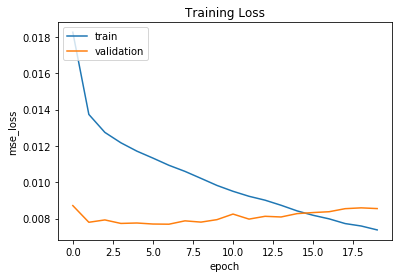

In [22]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Training Loss")
plt.ylabel("mse_loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc='upper left');

In [0]:
# load best weights into the model
model.load_weights("./hourly_models/model_6/weights_best.hdf5")

In [25]:
predictions = []
print("Start: ", datetime.datetime.now())
for arr in X_eval:
    # here array shape is (n_steps, rows, columns, n_features)
    yhat = model.predict(arr.reshape(1, n_steps, n_rows, n_columns, n_features))
    predictions.append(yhat)
predictions = np.array(predictions)
print("End: ", datetime.datetime.now())

Start:  2019-10-08 14:25:22.348316
End:  2019-10-08 14:25:58.957204


In [0]:
# load the scalar
scalar = joblib.load("./hourly_models/min_max_all_feat_72_to_48.pkl")

In [0]:
scores = list()
# calculate an RMSE score for each hour
# make the prediction shape as eval shape
pred = predictions.reshape(predictions.shape[0], predictions.shape[2])
#  0th index of scalar values will have details about global_active_power
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
for i in range(y_eval.shape[1]):
    # convert to original scale, we have used MinMaxScalar
    y_eval_inverse = y_eval[:, i] * mult_range + add_min
    pred_inverse = pred[:, i] * mult_range + add_min
    # calculate mse
    mse = mean_squared_error(y_eval_inverse, pred_inverse)
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)

Text(0, 0.5, 'Prediction Hours')

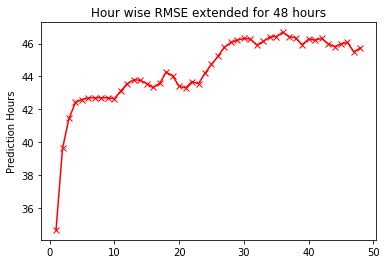

In [28]:
hours = np.arange(1,49)
plt.plot(hours, scores, marker='x', color="r")
plt.title("Hour wise RMSE extended for 48 hours")
plt.ylabel("RMSE global_active_power")
plt.ylabel("Prediction Hours")

In [29]:
# Checking overall RMSE
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
overall_mse = mean_squared_error(y_eval.flatten() * mult_range + add_min, pred.flatten() * mult_range + add_min)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 44.43


### Prediction

In [30]:
X_pred, y_pred = X_test, y_test
print("Pred X shape: ", X_pred.shape)
print("Pred y shape (in reality it won't be there): ", y_pred.shape)

Pred X shape:  (1, 3, 1, 24, 8)
Pred y shape (in reality it won't be there):  (1, 48)


In [0]:
# predict for next 48 hours
predictions = []
# looping so that we can have multiple prediction instances
for arr in X_pred:
    # here array shape is (n_steps, rows, columns, n_features)
    yhat = model.predict(arr.reshape(1, n_steps, n_rows, n_columns, n_features))
    predictions.append(yhat)
predictions = np.array(predictions)

In [0]:
# Convert to original scale
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
# just looping so that we can generate multiple prediction instance
original_scale_pred = []
for p in predictions:
    inv_scale_pred = p.flatten() * mult_range + add_min
    original_scale_pred.append(inv_scale_pred)

In [0]:
# Create a dataframe to share this (any other way)
df = pd.DataFrame({"local_time": pd.date_range(start="2010-11-24 21:00:00", end="2010-11-26 20:00:00", freq="H"), 
                   "global_active_power": original_scale_pred[0]})
df.set_index("local_time", inplace=True)

In [34]:
df.head()

,global_active_power
local_time,
2010-11-24 21:00:00,117.484703
2010-11-24 22:00:00,73.301262
2010-11-24 23:00:00,39.989979
2010-11-25 00:00:00,25.976334
2010-11-25 01:00:00,17.522011


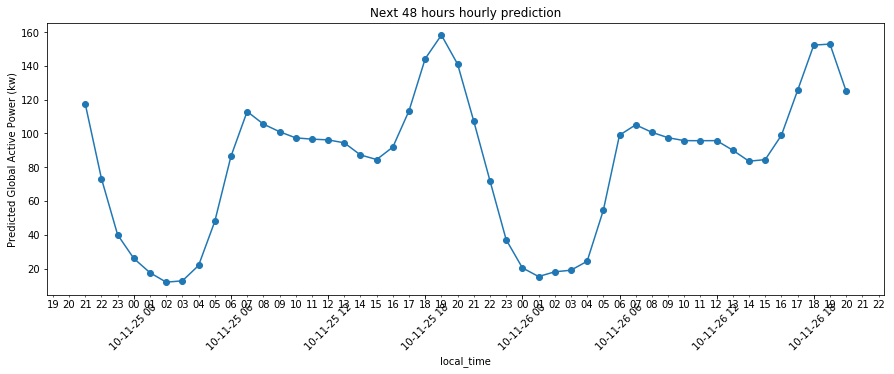

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

### Actual vs Prediction

In [0]:
df["actual_global_active_power"] = y_pred.flatten() * mult_range + add_min

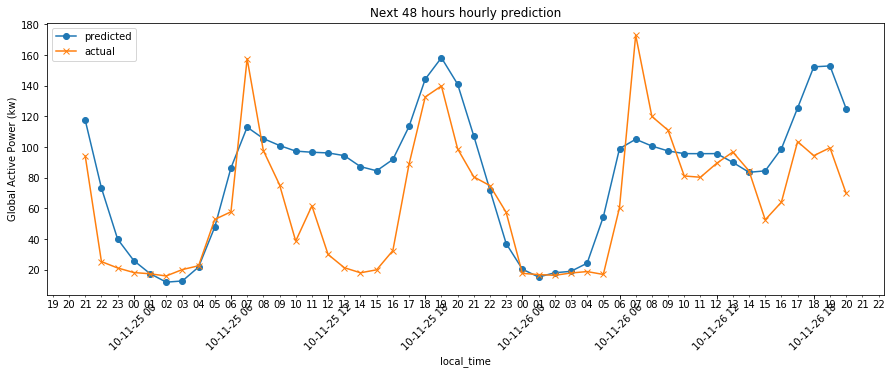

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.plot("actual_global_active_power", data=df, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);

### Conclusion:
1. Deep Learning models are doing far better than ML models.
2. Almost every model able to give RMSE less than 50.
3. Interesting point is all models failed to predict the dip on 25th Nove 2011. This basically throws us to the conclusion that we need other kind of features which might be able to relate to that dip.
4. Considering these models are not properly tuned with hyper-parameters, different optimizers, different convolution, with hand generated features (feature scaling), dropouts etc. still we are getting a satisfactory model compared to our hardworks.
5. To achieve this with ML, we might have spent significantly 10x times.